In [1]:
%matplotlib inline

from __future__ import division

from faculty_hiring.misc.util import *
from faculty_hiring.misc.plotting import *  # Definitions for LABEL_SIZE and such
from faculty_hiring.misc.productivity import *
from faculty_hiring.parse import faculty_parser, institution_parser
from faculty_hiring.parse import load

from random import choice
import numpy as np
import scipy as sp

# File locations
faculty_file = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/current_data/faculty_cs_CURRENT.txt'
inst_file = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/current_data/inst_cs_CURRENT.txt'

# (Optional, these are for loading publication profiles)
dblp_dir = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/profiles_DBLP_Nov16/'

In [2]:
inst = institution_parser.parse_institution_records(open(inst_file))
asst_faculty = load.load_assistant_profs(open(faculty_file), inst, ranking='pi')
ignore = ['All others', 'UNKNOWN', 'CUNY Graduate Center']

load.load_all_publications(asst_faculty, dblp_dir)

## Profile the Schools

Pre-compute all information that we'll need in order to match pairs of schools

In [3]:
# Number of publications for all current assistant faculty of a university. Adjusted for inflation
def publication_data(function = np.average, five_years_post_hire=False):
    pubs_by_inst = {}
    prestige_map = {}
    for (name, inst_data) in inst.items():
        if name in ignore:
            continue
        current_faculty = faculty_at_institution(name, asst_faculty)
        n_pubs = []
        for person in current_faculty:
            start = person.first_asst_job_year
            end = person.first_asst_job_year + 5
            if person.__contains__('dblp_pubs'):
                contribution = 0
                for pub in person.dblp_pubs:
                    if five_years_post_hire and pub['year'] > end:
                        continue
                    if 'year' in pub and pub['year'] >= start and pub['year'] < 2012 and pub['pub_type'] in ['inproceedings', 'article']:
                        contribution += inflation_adjust(pub['year'])
                n_pubs.append(contribution)

        pubs_by_inst[name] = {"total_pubs_by_author": function(n_pubs), "status": inst_data['private'], "rank": inst_data['pi']} 
        prestige_map[inst_data['pi']] = name
    
    return (pubs_by_inst, prestige_map)

pubs_by_inst, prestige_map = publication_data()

In [4]:
sorted_prestige_keys = sorted(prestige_map.keys())
sorted_prestige_names = [prestige_map[key] for key in sorted_prestige_keys]

## Match 'em

In [5]:
# How many private schools are there? How many public schools are there?
public = [(name, data) for (name, data) in pubs_by_inst.items() if data['status'] == 0]
private = [(name, data) for (name, data) in pubs_by_inst.items() if data['status'] == 1]

In [6]:
print("There are %d public schools and %d private schools (%d total)." % (len(public), len(private), len(public)+len(private)))

There are 151 public schools and 53 private schools (204 total).


In [7]:
def get_matched_pairs(public, private, skip=0.0):
    pairs = []
    scores = []
    
    available = {}
    for name, _ in public:
        available[name] = True
    
    possible_matches = len(private)
    grab = (1-skip)*possible_matches
    num_matches = 0
    
    # Go through all private schools
    for p1, p1_data in private:
        best_score = np.inf
        
        best_match = ""
        # Find a matching public school
        for p2, p2_data in public:
            # Only consider this school if we haven't already deleted it
            if available.has_key(p2):
                # Match on rank
                score = abs(p2_data["rank"] - p1_data["rank"]) # + np.random.random() ########
                if score < best_score:
                    best_match = p2
                    best_score = score
        
        del available[best_match]
        pairs.append((p1, best_match))
        scores.append(best_score)
 
        num_matches += 1
        if num_matches > grab:
            break
                
    return pairs, scores

In [8]:
pairs, scores = get_matched_pairs(public, private, skip=0.9)
for i, (p1, p2) in enumerate(pairs):
    print '%s (%s)\t<-->\t%s (%s)\tScore: %f' % (p1, "Private", p2, "Public", scores[i])
print "Total number of matches made: %d" % (len(pairs))

Brown University (Private)	<-->	University of Texas, Austin (Public)	Score: 2.480000
Rice University (Private)	<-->	UCLA (Public)	Score: 1.380000
MIT (Private)	<-->	UC Berkeley (Public)	Score: 1.210000
Pace University (Private)	<-->	New Mexico Institute of Mining and Technology (Public)	Score: 0.120000
Polytechnic Institute of NYU (Private)	<-->	University of Iowa (Public)	Score: 0.070000
Stanford University (Private)	<-->	University of Washington (Public)	Score: 8.830000
Total number of matches made: 6


In [9]:
total_trials = 0
num_positive = 0
advantages = []

for time in xrange(100):
    # Shuffle the private schools so we aren't always making the same matches
    np.random.shuffle(private)
    
    pairs,_ = get_matched_pairs(public, private, skip=0.9)
    for p1, p2 in pairs:
        # Who published more? Was this a private university?
        private_university = np.argmax([pubs_by_inst[p1]["rank"], pubs_by_inst[p2]["rank"]])
        published_more = np.argmax([pubs_by_inst[p1]["total_pubs_by_author"], pubs_by_inst[p2]["total_pubs_by_author"]])
        if private_university == published_more:
            num_positive += 1
            advantages.append(np.abs(pubs_by_inst[p1]["total_pubs_by_author"] - pubs_by_inst[p2]["total_pubs_by_author"]))
        total_trials += 1
    
print sp.stats.binom_test(num_positive, total_trials, .5, alternative='greater')

1.86064968904e-06


In [10]:
print float(num_positive) / total_trials

0.595


/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


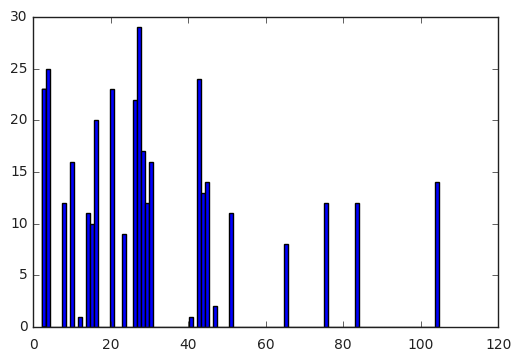

In [11]:
plt.hist(advantages, bins=100)
plt.show()

In [12]:
np.mean(advantages)

31.512527171489943

In [13]:
np.median(advantages)

27.492167595995376

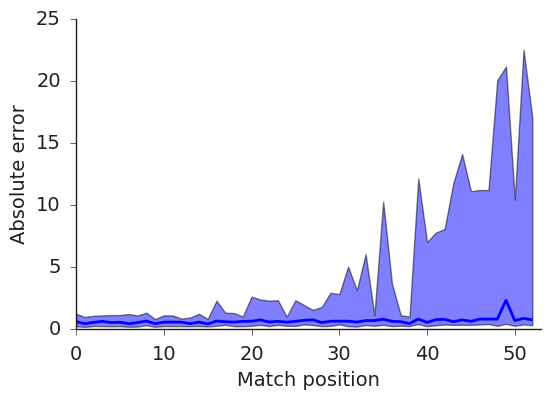

In [14]:
T = 100
scores = np.zeros((T, len(private)), dtype=float)

for t in xrange(T):
    np.random.shuffle(private)
    _, s = get_matched_pairs(public, private)
    scores[t, :] = np.array(s)

fig, ax = plt.subplots(1, 1, figsize=SINGLE_FIG_SIZE)
ylo = np.percentile(scores, 25, axis=0)
yhi = np.percentile(scores, 75, axis=0)

ax.fill_between(xrange(len(ylo)), ylo, yhi, alpha=0.5)
ax.plot(np.median(scores, axis=0), lw=LINE_WIDTH)

ax.set_xlim(0, len(ylo))
ax.set_xlabel('Match position')
ax.set_ylabel('Absolute error')
finalize(ax)
plt.show()

### Remove the Top 10

In [15]:
# How many private schools are there? How many public schools are there?
top = sorted_prestige_names[:10]
print(top)
bottom_public = [(name, data) for (name, data) in pubs_by_inst.items() if data['status'] == 0 and name not in top]
bottom_private = [(name, data) for (name, data) in pubs_by_inst.items() if data['status'] == 1 and name not in top]
print('Stanford University' in bottom_public)

['Stanford University', 'UC Berkeley', 'MIT', 'California Institute of Technology', 'Harvard University', 'Cornell University', 'Carnegie Mellon University', 'Princeton University', 'Yale University', 'University of Washington']
False


In [16]:
pairs, scores = get_matched_pairs(bottom_public, bottom_private, skip=0.9)
for i, (p1, p2) in enumerate(pairs):
    print '%s (%s)\t<-->\t%s (%s)\tScore: %f' % (p1, "Private", p2, "Public", scores[i])
print "Total number of matches made: %d" % (len(pairs))

Brown University (Private)	<-->	University of Texas, Austin (Public)	Score: 2.480000
Rice University (Private)	<-->	UCLA (Public)	Score: 1.380000
Pace University (Private)	<-->	New Mexico Institute of Mining and Technology (Public)	Score: 0.120000
Polytechnic Institute of NYU (Private)	<-->	University of Iowa (Public)	Score: 0.070000
University of Pennsylvania (Private)	<-->	University of Wisconsin, Madison (Public)	Score: 1.190000
Total number of matches made: 5


In [17]:
total_trials = 0
num_positive = 0
advantages = []

for time in xrange(100):
    # Shuffle the private schools so we aren't always making the same matches
    np.random.shuffle(bottom_private)
    
    pairs,_ = get_matched_pairs(bottom_public, bottom_private, skip=0.9)
    for p1, p2 in pairs:
        # Who published more? Was this a private university?
        private_university = np.argmax([pubs_by_inst[p1]["rank"], pubs_by_inst[p2]["rank"]])
        published_more = np.argmax([pubs_by_inst[p1]["total_pubs_by_author"], pubs_by_inst[p2]["total_pubs_by_author"]])
        if private_university == published_more:
            num_positive += 1
            advantages.append(np.abs(pubs_by_inst[p1]["total_pubs_by_author"] - pubs_by_inst[p2]["total_pubs_by_author"]))
        total_trials += 1
    
print sp.stats.binom_test(num_positive, total_trials, .5, alternative='greater')

1.09583794115e-09


In [18]:
print float(num_positive) / total_trials

0.634


In [23]:
# What about the top 20?
top = sorted_prestige_names[:20]
print(top)
bottom_public = [(name, data) for (name, data) in pubs_by_inst.items() if data['status'] == 0 and name not in top]
bottom_private = [(name, data) for (name, data) in pubs_by_inst.items() if data['status'] == 1 and name not in top]

pairs, scores = get_matched_pairs(bottom_public, bottom_private, skip=0.9)
for i, (p1, p2) in enumerate(pairs):
    print '%s (%s)\t<-->\t%s (%s)\tScore: %f' % (p1, "Private", p2, "Public", scores[i])
print "Total number of matches made: %d" % (len(pairs))

['Stanford University', 'UC Berkeley', 'MIT', 'California Institute of Technology', 'Harvard University', 'Cornell University', 'Carnegie Mellon University', 'Princeton University', 'Yale University', 'University of Washington', 'University of Illinois, Urbana Champaign', 'University of Wisconsin, Madison', 'University of Pennsylvania', 'Rice University', 'UCLA', 'New York University', 'University of Chicago', 'University of Texas, Austin', 'Brown University', 'Columbia University']
Pace University (Private)	<-->	New Mexico Institute of Mining and Technology (Public)	Score: 0.120000
Polytechnic Institute of NYU (Private)	<-->	University of Iowa (Public)	Score: 0.070000
Southern Methodist University (Private)	<-->	UC Santa Cruz (Public)	Score: 0.730000
University of Tulsa (Private)	<-->	Texas Tech University (Public)	Score: 0.220000
Total number of matches made: 4


In [24]:
total_trials = 0
num_positive = 0
advantages = []

for time in xrange(100):
    # Shuffle the private schools so we aren't always making the same matches
    np.random.shuffle(bottom_private)
    
    pairs,_ = get_matched_pairs(bottom_public, bottom_private, skip=0.9)
    for p1, p2 in pairs:
        # Who published more? Was this a private university?
        private_university = np.argmax([pubs_by_inst[p1]["rank"], pubs_by_inst[p2]["rank"]])
        published_more = np.argmax([pubs_by_inst[p1]["total_pubs_by_author"], pubs_by_inst[p2]["total_pubs_by_author"]])
        if private_university == published_more:
            num_positive += 1
            advantages.append(np.abs(pubs_by_inst[p1]["total_pubs_by_author"] - pubs_by_inst[p2]["total_pubs_by_author"]))
        total_trials += 1
    
print sp.stats.binom_test(num_positive, total_trials, .5, alternative='greater')

3.8404047475e-11


In [25]:
print float(num_positive) / total_trials

0.6625


### Only Consider Publications Within First Five Years of Hire

In [19]:
pubs_by_inst_limit, prestige_map_limit = publication_data(five_years_post_hire=True)

In [20]:
pairs, scores = get_matched_pairs(public, private, skip=0.9)
for i, (p1, p2) in enumerate(pairs):
    print '%s (%s)\t<-->\t%s (%s)\tScore: %f' % (p1, "Private", p2, "Public", scores[i])
print "Total number of matches made: %d" % (len(pairs))

University of Chicago (Private)	<-->	University of Texas, Austin (Public)	Score: 0.620000
Nova Southeastern University (Private)	<-->	University of Arkansas, Fayetteville (Public)	Score: 0.150000
Southern Methodist University (Private)	<-->	UC Santa Cruz (Public)	Score: 0.730000
Lehigh University (Private)	<-->	College of William and Mary (Public)	Score: 1.270000
Toyota Technological Institute at Chicago (Private)	<-->	University of Rhode Island (Public)	Score: 0.160000
Clarkson University (Private)	<-->	New Mexico State University (Public)	Score: 0.180000
Total number of matches made: 6


In [21]:
total_trials = 0
num_positive = 0
advantages = []

for time in xrange(100):
    # Shuffle the private schools so we aren't always making the same matches
    np.random.shuffle(private)
    
    pairs,_ = get_matched_pairs(public, private, skip=0.9)
    for p1, p2 in pairs:
        # Who published more? Was this a private university?
        private_university = np.argmax([pubs_by_inst_limit[p1]["rank"], pubs_by_inst_limit[p2]["rank"]])
        published_more = np.argmax([pubs_by_inst_limit[p1]["total_pubs_by_author"], pubs_by_inst_limit[p2]["total_pubs_by_author"]])
        if private_university == published_more:
            num_positive += 1
            advantages.append(np.abs(pubs_by_inst_limit[p1]["total_pubs_by_author"] - pubs_by_inst_limit[p2]["total_pubs_by_author"]))
        total_trials += 1
    
print sp.stats.binom_test(num_positive, total_trials, .5, alternative='greater')

2.49632598542e-08


In [22]:
print float(num_positive) / total_trials

0.611666666667
